# Precision Volatility Forecasting for Strategic Quote Placement in High-Frequency Trading

In [ ]:
# automatically installs dependencies if they’re not already installed 
from install_packages import install_dependencies

install_dependencies()


Installing: scikit-learn
Installing: torchaudio==2.1.0
Installing: ipython
Requirements satisfied. Installed: ['scikit-learn', 'torchaudio==2.1.0', 'ipython']


In [108]:
import os
import pandas as pd
import numpy as np
import random
import importlib

import models.util as util
importlib.reload(util)

<module 'models.util' from '/Users/kang/Projects/volatility-analysis/models/util.py'>

In [ ]:
# Set path to local data directory
folder_path = "data"
feature_path = os.path.join(folder_path, "order_book_feature.parquet")
target_path = os.path.join(folder_path, "order_book_target.parquet")

# Load and combine parquet files
feature_df = pd.read_parquet(feature_path, engine='pyarrow')
target_df = pd.read_parquet(target_path, engine='pyarrow')
combined_df = pd.concat([feature_df, target_df], axis=0)
combined_df = combined_df.sort_values(by=['stock_id', 'time_id', 'seconds_in_bucket']).reset_index(drop=True)

# Load time reference
time_ref_path = os.path.join(folder_path, "time_id_reference.csv")
time_ref_df = pd.read_csv(time_ref_path)
time_ref_df["datetime"] = pd.to_datetime(time_ref_df["date"] + " " + time_ref_df["time"])

# Filter one stock for now
df_single_stock = combined_df[combined_df["stock_id"] == 50200].
copy()

# Step 1: Compute snapshot features
snapshot_features_df = util.create_snapshot_features(df_single_stock)

# Step 2: Compute rolling-window training set
rolling_features_df = util.generate_rolling_features(snapshot_features_df)

# Merge time_id to datetime (optional for plotting/debugging)
rolling_features_df = pd.merge(
    rolling_features_df.drop(columns=["datetime"], errors="ignore"),
    time_ref_df[["time_id", "datetime"]],
    on="time_id",
    how="left"
)

# Preview
print("Rolling features:", rolling_features_df.shape)
display(rolling_features_df.head())

print("Rolling features:", snapshot_features_df.shape)
display(snapshot_features_df.head())

Rolling features: (833291, 25)


,stock_id,time_id,start_time,wap_mean,wap_std,wap_max,wap_min,spread_pct_mean,spread_pct_std,spread_pct_max,...,depth_ratio_mean,depth_ratio_std,depth_ratio_max,depth_ratio_min,log_return_mean,log_return_std,log_return_max,log_return_min,realized_volatility,datetime
0,50200.0,6.0,1800.0,372.347747,0.152688,372.598023,372.036666,0.000037,0.000013,0.000054,...,7.589939,44.479523,395.999604,0.033333,-0.000003,0.000046,0.000159,-0.000207,0.000227,NaT
1,50200.0,6.0,1802.0,372.340905,0.156816,372.598023,371.955111,0.000038,0.000013,0.000054,...,7.582752,44.480654,395.999604,0.033333,-0.000004,0.000048,0.000159,-0.000219,0.000060,NaT
2,50200.0,6.0,1805.0,372.332872,0.163290,372.598023,371.934998,0.000038,0.000013,0.000054,...,7.566621,44.482415,395.999604,0.033333,-0.000004,0.000048,0.000159,-0.000219,0.000351,NaT
3,50200.0,6.0,1807.0,372.326948,0.165921,372.598023,371.934998,0.000037,0.000013,0.000054,...,7.510483,44.485172,395.999604,0.033333,-0.000004,0.000051,0.000340,-0.000219,0.000066,NaT
4,50200.0,6.0,1810.0,372.319845,0.168082,372.598023,371.934998,0.000037,0.000013,0.000054,...,7.508179,44.485539,395.999604,0.033333,-0.000004,0.000050,0.000340,-0.000219,0.000148,NaT


Rolling features: (4166788, 18)


,stock_id,time_id,seconds_in_bucket,bid_price1,ask_price1,bid_price2,ask_price2,bid_size1,ask_size1,bid_size2,ask_size2,mid_price,wap,bid_ask_spread,spread_pct,imbalance,depth_ratio,log_return
27224315,50200,6,1800.0,372.48,372.50,372.47,372.51,200,200,1408,510,372.490,372.489999,0.02,0.000054,0.000000,1.000000,0.000000
27224316,50200,6,1800.0,372.48,372.50,372.47,372.51,200,200,1408,510,372.490,372.489999,0.02,0.000054,0.000000,1.000000,0.000000
27224317,50200,6,1801.0,372.47,372.48,372.46,372.49,435,830,608,300,372.475,372.473438,0.01,0.000027,-0.312253,0.524096,-0.000044
27224318,50200,6,1801.0,372.47,372.48,372.46,372.49,435,830,608,300,372.475,372.473438,0.01,0.000027,-0.312253,0.524096,0.000000
27224319,50200,6,1802.0,372.46,372.47,372.45,372.48,100,100,508,1500,372.465,372.464998,0.01,0.000027,0.000000,1.000000,-0.000023


=== HAR-RV Baseline Evaluation ===
MSE: 0.00000001
RMSE: 0.00009405
QLIKE: 1.5664
Directional Accuracy: 0.2966


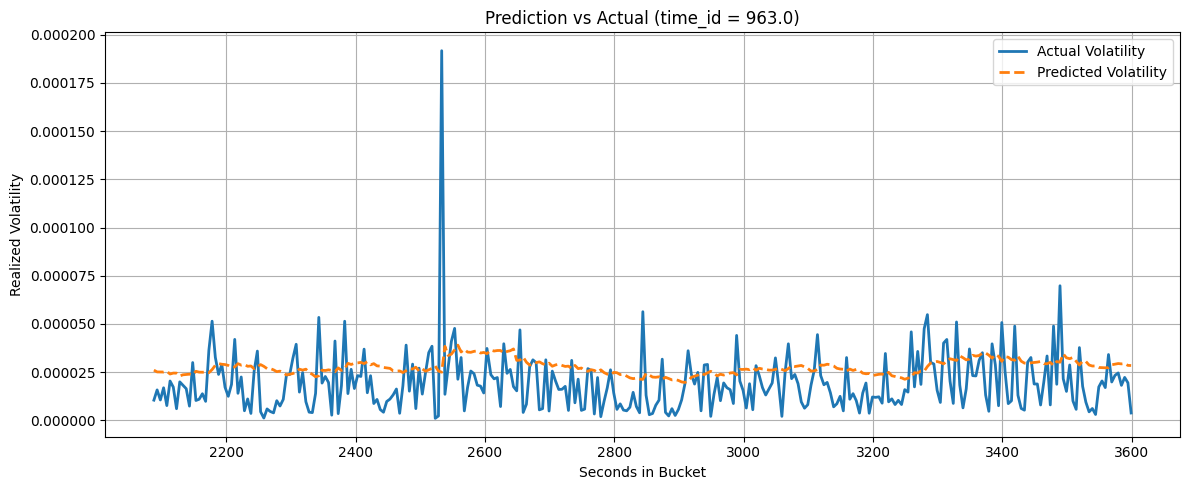

In [110]:
import models.har_rv as har_rv
importlib.reload(har_rv)

model_rv_ols, test_df_ols = har_rv.ols(rolling_features_df)

util.plot_prediction_vs_actual(
    df=test_df_ols,
    time_id=test_df_ols['time_id'].iloc[0],
    y_true_col='realized_volatility',
    y_pred_col='y_pred'
)

=== HAR-RV WLS Baseline Evaluation ===
MSE: 0.00000001
RMSE: 0.00009495
QLIKE: 2.1987
Directional Accuracy: 0.2971


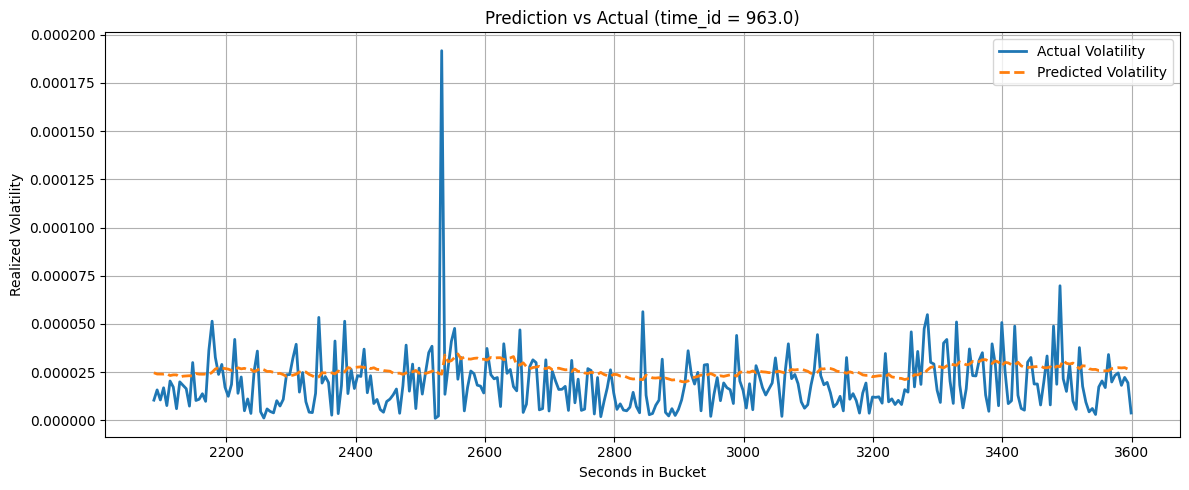

In [111]:
model_wls, test_df_wls = har_rv.wls(rolling_features_df)

util.plot_prediction_vs_actual(
    df=test_df_wls,
    time_id=test_df_wls['time_id'].iloc[0],
    y_true_col='realized_volatility',
    y_pred_col='y_pred'
)

In [112]:
import models.lstm as lstm
importlib.reload(lstm)

subset_time_ids = snapshot_features_df['time_id'].unique()[:400]
df_subset = snapshot_features_df[snapshot_features_df['time_id'].isin(subset_time_ids)].copy()
lstm_df = util.generate_tick_sequences(df_subset, feature_cols=["wap","spread_pct","imbalance","depth_ratio","log_return"])

In [113]:
importlib.reload(lstm)
model_lstm_baseline, history_lstm_baseline, test_df_lstm_baseline = lstm.baseline(lstm_df)

Epoch 1/50
6521/6521 ━━━━━━━━━━━━━━━━━━━━ 200s 30ms/step - loss: 0.5309 - val_loss: 0.2118 - learning_rate: 1.0000e-04
Epoch 2/50
6521/6521 ━━━━━━━━━━━━━━━━━━━━ 196s 30ms/step - loss: 0.3777 - val_loss: 0.2101 - learning_rate: 1.0000e-04
Epoch 3/50
6521/6521 ━━━━━━━━━━━━━━━━━━━━ 197s 30ms/step - loss: 0.3784 - val_loss: 0.2157 - learning_rate: 1.0000e-04
Epoch 4/50
6521/6521 ━━━━━━━━━━━━━━━━━━━━ 197s 30ms/step - loss: 0.3688 - val_loss: 0.2314 - learning_rate: 1.0000e-04
Epoch 5/50
6521/6521 ━━━━━━━━━━━━━━━━━━━━ 198s 30ms/step - loss: 0.3739 - val_loss: 0.2035 - learning_rate: 1.0000e-04
Epoch 6/50
6521/6521 ━━━━━━━━━━━━━━━━━━━━ 199s 30ms/step - loss: 0.3701 - val_loss: 0.2117 - learning_rate: 1.0000e-04
Epoch 7/50
6521/6521 ━━━━━━━━━━━━━━━━━━━━ 199s 31ms/step - loss: 0.3713 - val_loss: 0.2065 - learning_rate: 1.0000e-04
Epoch 8/50
6521/6521 ━━━━━━━━━━━━━━━━━━━━ 199s 31ms/step - loss: 0.3613 - val_loss: 0.2180 - learning_rate: 1.0000e-04
Epoch 9/50
6521/6521 ━━━━━━━━━━━━━━━━━━━━ 199s 3

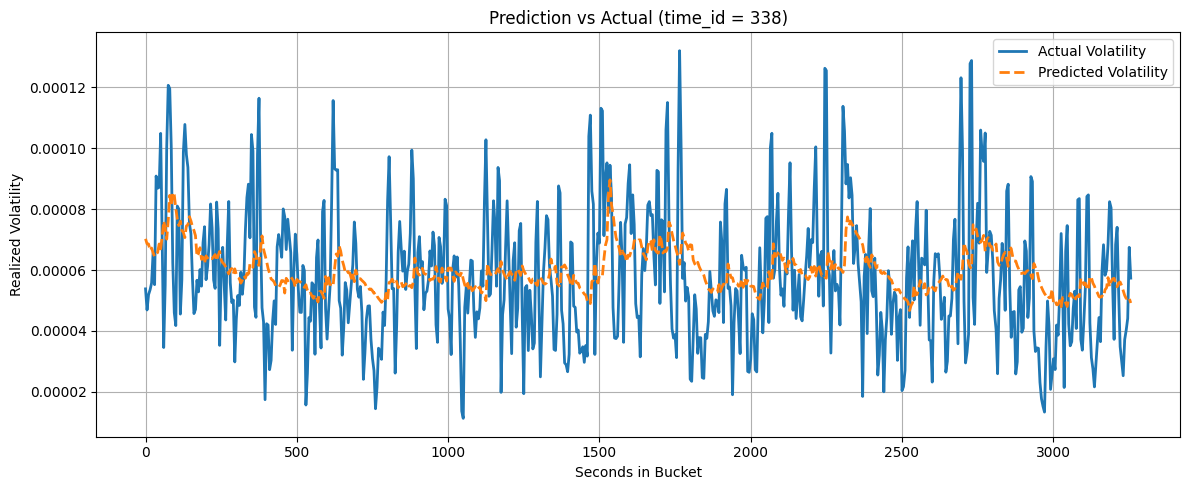

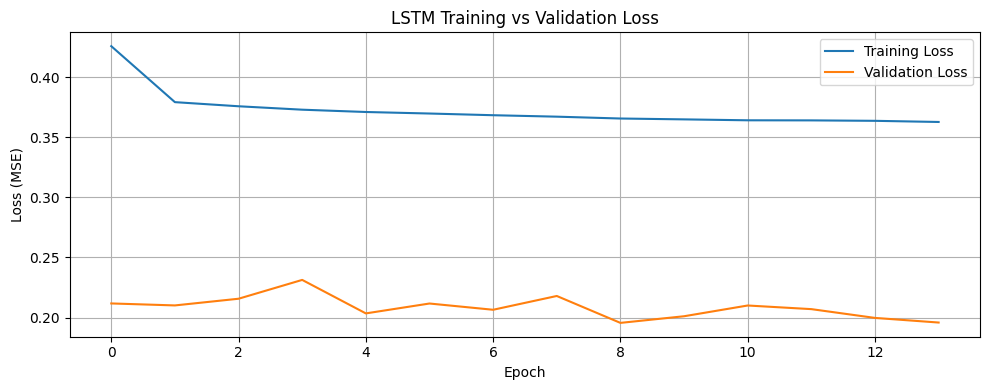

In [114]:
#test_df_lstm['time_id'].iloc[1]

util.plot_prediction_vs_actual(
    df=test_df_lstm_baseline,
    time_id=test_df_lstm_baseline['time_id'].iloc[1],
    y_true_col="y_true",
    y_pred_col="y_pred"
)

util.plot_training_loss(history_lstm_baseline)

In [115]:
model_lstm_v256d03, history_lstm_v256d03, test_df_lstm_v256d03 = lstm.config_v256d03(lstm_df)

Epoch 1/50
6521/6521 ━━━━━━━━━━━━━━━━━━━━ 274s 42ms/step - loss: 0.4674 - val_loss: 0.1969 - learning_rate: 1.0000e-04
Epoch 2/50
6521/6521 ━━━━━━━━━━━━━━━━━━━━ 271s 41ms/step - loss: 0.3821 - val_loss: 0.2098 - learning_rate: 1.0000e-04
Epoch 3/50
6521/6521 ━━━━━━━━━━━━━━━━━━━━ 3984s 611ms/step - loss: 0.3853 - val_loss: 0.2197 - learning_rate: 1.0000e-04
Epoch 4/50
6521/6521 ━━━━━━━━━━━━━━━━━━━━ 1199s 184ms/step - loss: 0.3750 - val_loss: 0.2025 - learning_rate: 1.0000e-04
Epoch 5/50
6521/6521 ━━━━━━━━━━━━━━━━━━━━ 274s 42ms/step - loss: 0.3700 - val_loss: 0.1901 - learning_rate: 1.0000e-04
Epoch 6/50
6521/6521 ━━━━━━━━━━━━━━━━━━━━ 274s 42ms/step - loss: 0.3653 - val_loss: 0.2058 - learning_rate: 1.0000e-04
Epoch 7/50
6521/6521 ━━━━━━━━━━━━━━━━━━━━ 2191s 336ms/step - loss: 0.3662 - val_loss: 0.1889 - learning_rate: 1.0000e-04
Epoch 8/50
6521/6521 ━━━━━━━━━━━━━━━━━━━━ 273s 42ms/step - loss: 0.3649 - val_loss: 0.1920 - learning_rate: 1.0000e-04
Epoch 9/50
6521/6521 ━━━━━━━━━━━━━━━━━━━━ 

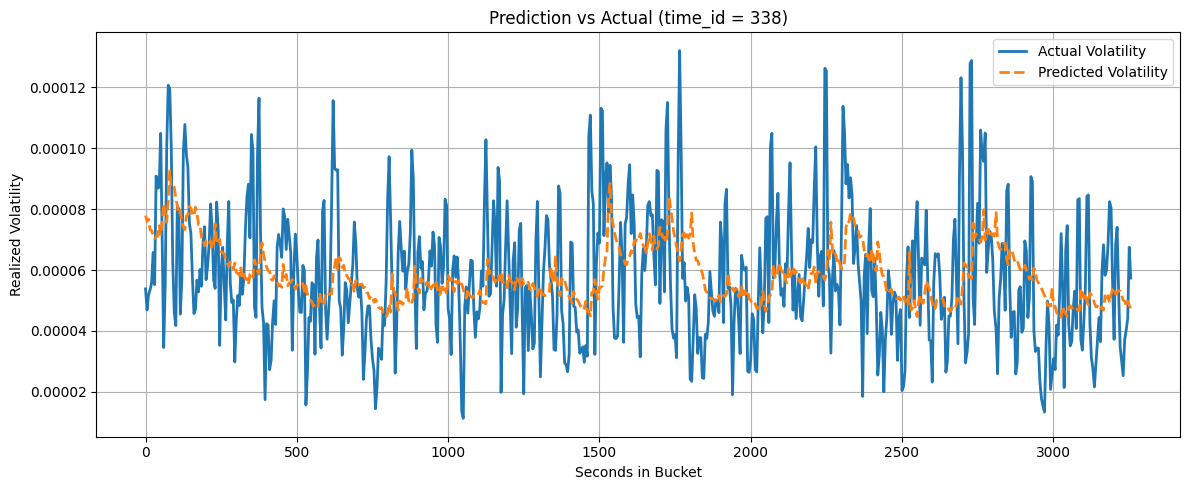

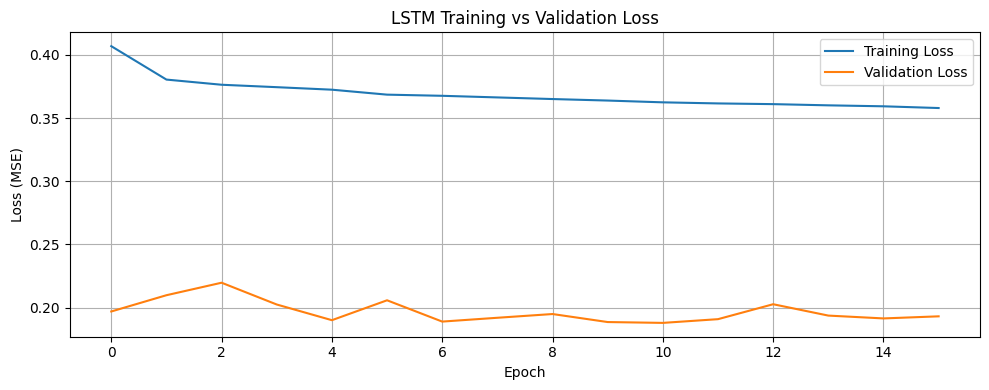

In [116]:
util.plot_prediction_vs_actual(
    df=test_df_lstm_v256d03,
    time_id=test_df_lstm_v256d03['time_id'].iloc[1],
    y_true_col="y_true",
    y_pred_col="y_pred"
)

util.plot_training_loss(history_lstm_v256d03)

In [117]:
snapshot_more_feature_df = util.add_features(snapshot_features_df)
feature_cols = ["wap", "spread_pct", "imbalance", "depth_ratio", "log_return",
                "log_wap_change", "rolling_std_logret", "spread_zscore", "volume_imbalance"]


subset_time_ids = snapshot_more_feature_df['time_id'].unique()[:400]
df_subset = snapshot_more_feature_df[snapshot_more_feature_df['time_id'].isin(subset_time_ids)].copy()
lstm_df_more_feature = util.generate_tick_sequences(df_subset, feature_cols)

In [118]:
model_lstm_more_feature, history_lstm_more_feature, test_df_lstm_more_feature = lstm.config_v256d03(lstm_df_more_feature)

Epoch 1/50
6521/6521 ━━━━━━━━━━━━━━━━━━━━ 561s 85ms/step - loss: 0.4247 - val_loss: 0.2038 - learning_rate: 1.0000e-04
Epoch 2/50
6521/6521 ━━━━━━━━━━━━━━━━━━━━ 549s 84ms/step - loss: 0.3773 - val_loss: 0.1943 - learning_rate: 1.0000e-04
Epoch 3/50
6521/6521 ━━━━━━━━━━━━━━━━━━━━ 377s 58ms/step - loss: 0.3769 - val_loss: 0.1930 - learning_rate: 1.0000e-04
Epoch 4/50
6521/6521 ━━━━━━━━━━━━━━━━━━━━ 302s 46ms/step - loss: 0.3650 - val_loss: 0.1915 - learning_rate: 1.0000e-04
Epoch 5/50
6521/6521 ━━━━━━━━━━━━━━━━━━━━ 305s 47ms/step - loss: 0.3609 - val_loss: 0.1970 - learning_rate: 1.0000e-04
Epoch 6/50
6521/6521 ━━━━━━━━━━━━━━━━━━━━ 305s 47ms/step - loss: 0.3640 - val_loss: 0.2088 - learning_rate: 1.0000e-04
Epoch 7/50
6521/6521 ━━━━━━━━━━━━━━━━━━━━ 305s 47ms/step - loss: 0.3614 - val_loss: 0.1909 - learning_rate: 1.0000e-04
Epoch 8/50
6521/6521 ━━━━━━━━━━━━━━━━━━━━ 301s 46ms/step - loss: 0.3638 - val_loss: 0.1877 - learning_rate: 1.0000e-04
Epoch 9/50
6521/6521 ━━━━━━━━━━━━━━━━━━━━ 303s 4

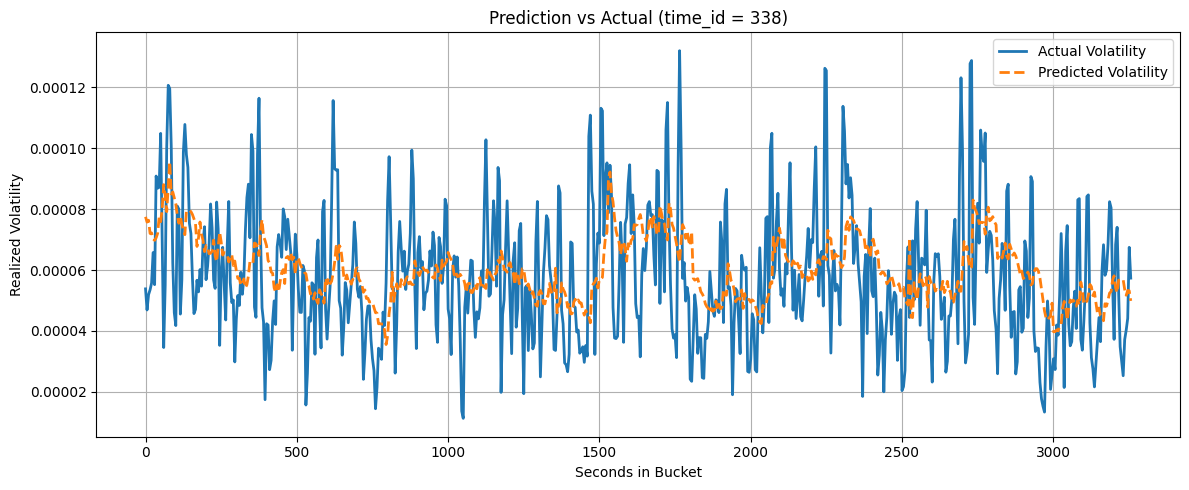

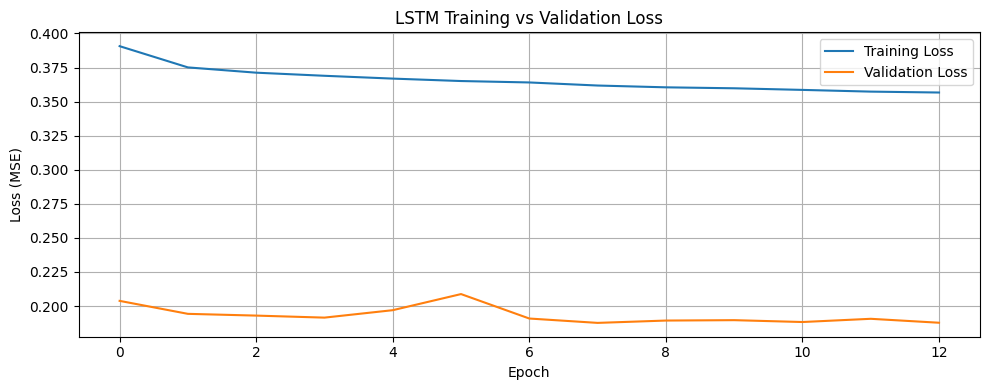

In [119]:
util.plot_prediction_vs_actual(
    df=test_df_lstm_more_feature,
    time_id=test_df_lstm_more_feature['time_id'].iloc[1],
    y_true_col="y_true",
    y_pred_col="y_pred"
)

util.plot_training_loss(history_lstm_more_feature)

In [120]:
import models.garch as garch
importlib.reload(garch)

selected_ids = rolling_features_df["time_id"].drop_duplicates().sort_values().iloc[:400]

rolling_subset = rolling_features_df[rolling_features_df["time_id"].isin(selected_ids)].reset_index(drop=True)
snapshot_subset = snapshot_features_df[snapshot_features_df["time_id"].isin(selected_ids)].reset_index(drop=True)

print(rolling_subset.keys())
print(snapshot_subset.keys())

Index(['stock_id', 'time_id', 'start_time', 'wap_mean', 'wap_std', 'wap_max',
       'wap_min', 'spread_pct_mean', 'spread_pct_std', 'spread_pct_max',
       'spread_pct_min', 'imbalance_mean', 'imbalance_std', 'imbalance_max',
       'imbalance_min', 'depth_ratio_mean', 'depth_ratio_std',
       'depth_ratio_max', 'depth_ratio_min', 'log_return_mean',
       'log_return_std', 'log_return_max', 'log_return_min',
       'realized_volatility', 'datetime'],
      dtype='object')
Index(['stock_id', 'time_id', 'seconds_in_bucket', 'bid_price1', 'ask_price1',
       'bid_price2', 'ask_price2', 'bid_size1', 'ask_size1', 'bid_size2',
       'ask_size2', 'mid_price', 'wap', 'bid_ask_spread', 'spread_pct',
       'imbalance', 'depth_ratio', 'log_return'],
      dtype='object')


In [121]:
importlib.reload(garch)
model, result_df = garch.baseline(rolling_subset, snapshot_subset)

Running ARMA-GARCH forecast...


Processing: 100%|██████████| 57571/57571 [07:21<00:00, 130.34it/s]

=== ARMA-GARCH Baseline Evaluation (on test set) ===
MSE: 0.00000001
RMSE: 0.00007823
QLIKE: 1.2834
Directional Accuracy: 0.4988
Success Rate: 52306/57571


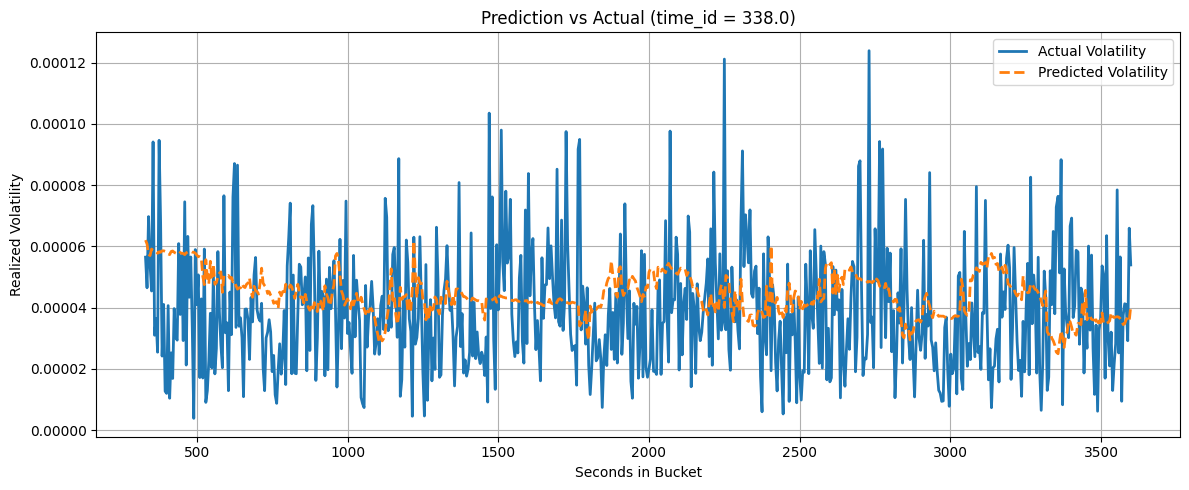

In [122]:
util.plot_prediction_vs_actual(
    df=result_df,
    time_id=result_df['time_id'].iloc[1],
    y_true_col="y_true",
    y_pred_col="y_pred"
)

In [123]:
importlib.reload(garch)

model_garch_grid, result_df_garch_grid = garch.baseline_grid(
    rolling_df=rolling_subset,
    full_df=snapshot_subset,
    p_values=[1, 2, 3], 
    q_values=[1, 2, 3],
    scale=1000000
)


🔍 Grid search over (p, q) combinations: [(1, 1), (1, 2), (1, 3), (2, 1), (2, 2), (2, 3), (3, 1), (3, 2), (3, 3)]

▶ Evaluating GARCH(1,1)


GARCH(1,1):   0%|          | 0/57571 [00:00<?, ?it/s]

GARCH(1,1): 100%|██████████| 57571/57571 [07:17<00:00, 131.45it/s]


    → RMSE = 0.00008846, QLIKE = 1.0773, Directional Accuracy = 0.4992

▶ Evaluating GARCH(1,2)


GARCH(1,2):  67%|██████▋   | 38849/57571 [06:47<03:23, 91.90it/s] /Users/kang/Projects/volatility-analysis/.conda/lib/python3.11/site-packages/arch/univariate/base.py:768: ConvergenceWarning: The optimizer returned code 9. The message is:
Iteration limit reached
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
/Users/kang/Projects/volatility-analysis/.conda/lib/python3.11/site-packages/arch/univariate/base.py:768: ConvergenceWarning: The optimizer returned code 9. The message is:
Iteration limit reached
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
/Users/kang/Projects/volatility-analysis/.conda/lib/python3.11/site-packages/arch/univariate/base.py:768: ConvergenceWarning: The optimizer returned code 9. The message is:
Iteration limit reached
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
GARCH(1,2): 100%|██████████| 57571/57571 [09:56<00:00, 96.56it/s] 


    → RMSE = 0.00008856, QLIKE = 1.0770, Directional Accuracy = 0.4997

▶ Evaluating GARCH(1,3)


GARCH(1,3):   5%|▌         | 3131/57571 [00:39<14:18, 63.40it/s] /Users/kang/Projects/volatility-analysis/.conda/lib/python3.11/site-packages/arch/univariate/base.py:768: ConvergenceWarning: The optimizer returned code 9. The message is:
Iteration limit reached
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
GARCH(1,3):  25%|██▌       | 14570/57571 [03:07<07:53, 90.72it/s] /Users/kang/Projects/volatility-analysis/.conda/lib/python3.11/site-packages/arch/univariate/base.py:768: ConvergenceWarning: The optimizer returned code 9. The message is:
Iteration limit reached
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
GARCH(1,3):  30%|██▉       | 17123/57571 [03:42<10:31, 64.04it/s] /Users/kang/Projects/volatility-analysis/.conda/lib/python3.11/site-packages/arch/univariate/base.py:768: ConvergenceWarning: The optimizer returned code 9. The message is:
Iteration limit reached
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
GARCH(1,3):  3

    → RMSE = 0.00008860, QLIKE = 1.0778, Directional Accuracy = 0.5005

▶ Evaluating GARCH(2,1)


GARCH(2,1): 100%|██████████| 57571/57571 [09:08<00:00, 104.99it/s]


    → RMSE = 0.00008847, QLIKE = 1.0735, Directional Accuracy = 0.5019

▶ Evaluating GARCH(2,2)


GARCH(2,2):  27%|██▋       | 15290/57571 [03:16<09:55, 71.00it/s] /Users/kang/Projects/volatility-analysis/.conda/lib/python3.11/site-packages/arch/univariate/base.py:768: ConvergenceWarning: The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
GARCH(2,2):  50%|████▉     | 28507/57571 [06:12<07:36, 63.64it/s] /Users/kang/Projects/volatility-analysis/.conda/lib/python3.11/site-packages/arch/univariate/base.py:768: ConvergenceWarning: The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
GARCH(2,2):  60%|██████    | 34711/57571 [07:34<04:39, 81.83it/s] /Users/kang/Projects/volatility-analysis/.conda/lib/python3.11/site-packages/arch/univariate/base.py:768: ConvergenceWarning: The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.

    → RMSE = 0.00008861, QLIKE = 1.0741, Directional Accuracy = 0.5006

▶ Evaluating GARCH(2,3)


GARCH(2,3):   5%|▍         | 2827/57571 [00:43<19:48, 46.08it/s] /Users/kang/Projects/volatility-analysis/.conda/lib/python3.11/site-packages/arch/univariate/base.py:768: ConvergenceWarning: The optimizer returned code 9. The message is:
Iteration limit reached
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
GARCH(2,3):   9%|▉         | 5265/57571 [01:20<13:44, 63.45it/s] /Users/kang/Projects/volatility-analysis/.conda/lib/python3.11/site-packages/arch/univariate/base.py:768: ConvergenceWarning: The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
GARCH(2,3):  29%|██▉       | 16683/57571 [05:24<08:05, 84.14it/s]  /Users/kang/Projects/volatility-analysis/.conda/lib/python3.11/site-packages/arch/univariate/base.py:768: ConvergenceWarning: The optimizer returned code 9. The message is:
Iteration limit reached
See scipy.optimize.fmin_slsqp for code meaning.

  warnin

    → RMSE = 0.00008866, QLIKE = 1.0829, Directional Accuracy = 0.5009

▶ Evaluating GARCH(3,1)


GARCH(3,1): 100%|██████████| 57571/57571 [11:10<00:00, 85.89it/s] 


    → RMSE = 0.00008853, QLIKE = 1.0759, Directional Accuracy = 0.5027

▶ Evaluating GARCH(3,2)


GARCH(3,2):  47%|████▋     | 27210/57571 [07:04<09:12, 54.95it/s] /Users/kang/Projects/volatility-analysis/.conda/lib/python3.11/site-packages/arch/univariate/base.py:768: ConvergenceWarning: The optimizer returned code 9. The message is:
Iteration limit reached
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
GARCH(3,2):  52%|█████▏    | 30069/57571 [07:50<07:42, 59.42it/s] /Users/kang/Projects/volatility-analysis/.conda/lib/python3.11/site-packages/arch/univariate/base.py:768: ConvergenceWarning: The optimizer returned code 9. The message is:
Iteration limit reached
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
GARCH(3,2):  53%|█████▎    | 30753/57571 [08:00<08:02, 55.63it/s] /Users/kang/Projects/volatility-analysis/.conda/lib/python3.11/site-packages/arch/univariate/base.py:768: ConvergenceWarning: The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  warni

    → RMSE = 0.00008865, QLIKE = 1.0776, Directional Accuracy = 0.4992

▶ Evaluating GARCH(3,3)


GARCH(3,3):  27%|██▋       | 15508/57571 [04:43<12:42, 55.18it/s] /Users/kang/Projects/volatility-analysis/.conda/lib/python3.11/site-packages/arch/univariate/base.py:768: ConvergenceWarning: The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
GARCH(3,3):  51%|█████     | 29118/57571 [09:07<08:44, 54.26it/s] /Users/kang/Projects/volatility-analysis/.conda/lib/python3.11/site-packages/arch/univariate/base.py:768: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
GARCH(3,3):  53%|█████▎    | 30761/57571 [09:38<07:36, 58.70it/s] /Users/kang/Projects/volatility-analysis/.conda/lib/python3.11/site-packages/arch/univariate/base.py:768: ConvergenceWarning: The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fm

    → RMSE = 0.00008870, QLIKE = 1.0861, Directional Accuracy = 0.5025

✅ Grid Search Complete. Best Model Summary:
                           AR - GARCH Model Results                           
Dep. Variable:                      y   R-squared:                       0.009
Mean Model:                        AR   Adj. R-squared:                  0.006
Vol Model:                      GARCH   Log-Likelihood:               -1294.82
Distribution:                  Normal   AIC:                           2599.65
Method:            Maximum Likelihood   BIC:                           2618.63
                                        No. Observations:                  329
Date:                Mon, May 12 2025   Df Residuals:                      327
Time:                        09:55:45   Df Model:                            2
                                Mean Model                                
                 coef    std err          t      P>|t|    95.0% Conf. Int.
-----------------------

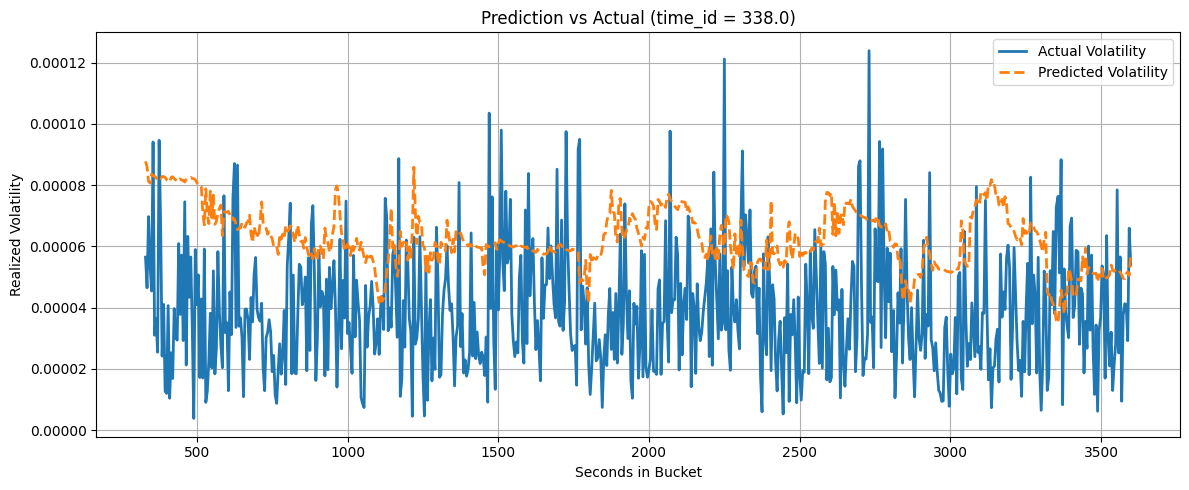

In [124]:
util.plot_prediction_vs_actual(
    df=result_df_garch_grid,
    time_id=result_df_garch_grid['time_id'].iloc[1],
    y_true_col="y_true",
    y_pred_col="y_pred"
)